<a href="https://colab.research.google.com/github/dquangucsd/Lab2_Starter/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L -o ./classical-music-midi.zip\
  https://www.kaggle.com/api/v1/datasets/download/soumikrakshit/classical-music-midi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2388k  100 2388k    0     0  2582k      0 --:--:-- --:--:-- --:--:-- 2582k


In [2]:
!ls midis

ls: cannot access 'midis': No such file or directory


In [3]:
!mkdir midis

In [4]:
!ls midis

In [5]:
!mv classical-music-midi.zip midis/

In [6]:
!ls midis

classical-music-midi.zip


In [7]:
!unzip ./midis/classical-music-midi.zip

Archive:  ./midis/classical-music-midi.zip
  inflating: albeniz/alb_esp1.mid    
  inflating: albeniz/alb_esp2.mid    
  inflating: albeniz/alb_esp3.mid    
  inflating: albeniz/alb_esp4.mid    
  inflating: albeniz/alb_esp5.mid    
  inflating: albeniz/alb_esp6.mid    
  inflating: albeniz/alb_se1.mid     
  inflating: albeniz/alb_se2.mid     
  inflating: albeniz/alb_se3.mid     
  inflating: albeniz/alb_se4.mid     
  inflating: albeniz/alb_se5.mid     
  inflating: albeniz/alb_se6.mid     
  inflating: albeniz/alb_se7.mid     
  inflating: albeniz/alb_se8.mid     
  inflating: bach/bach_846.mid       
  inflating: bach/bach_847.mid       
  inflating: bach/bach_850.mid       
  inflating: balakir/islamei.mid     
  inflating: beeth/appass_1.mid      
  inflating: beeth/appass_2.mid      
  inflating: beeth/appass_3.mid      
  inflating: beeth/beethoven_hammerklavier_1.mid  
  inflating: beeth/beethoven_hammerklavier_2.mid  
  inflating: beeth/beethoven_hammerklavier_3.mid  
  infl

In [8]:
from glob import glob

In [9]:
midi_files = glob('chopin/*.mid')

In [10]:
len(midi_files)

48

In [11]:
!pip install tensorflow


In [12]:
!pip install music21

In [13]:
!pip install seaborn

In [14]:
!pip install pydot

In [15]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax, Adam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [16]:
!which lilypond

In [17]:
import os

In [18]:
from tqdm import tqdm

In [19]:
#Loading the list of chopin's midi files as stream
filepath = "./chopin/"
#Getting midi files
all_midis= []
for i in tqdm(os.listdir(filepath)):
    if i.endswith(".mid"):
        tr = filepath+i
        try:
            midi = converter.parse(tr)
        except Exception as e:
            print(f"Error parsing {tr}: {e}")
            continue
        all_midis.append(midi)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [02:18<00:00,  2.89s/it]


In [45]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


In [46]:
print("First fifty values in the Corpus:", Corpus[:50])


First fifty values in the Corpus: ['B4', 'A4', 'C#4', 'G3', 'B4', 'A2', 'E5', 'G3', 'A4', 'E4', 'C#4', 'G3', 'B-4', 'A2', 'E5', 'G3', 'A4', 'E4', 'C#4', 'G3', 'B4', 'A2', 'E5', 'B4', 'G3', 'A4', 'E4', 'C#4', 'G3', 'B-4', 'A2', 'E5', 'G3', 'A4', 'E4', 'C#4', 'A3', 'B4', 'A2', 'E5', 'G3', 'A4', 'E4', 'C#4', 'G3', 'F#4', 'A3', 'D4', 'D2', 'A3']


In [22]:
# #First Lets write some functions that we need to look into the data
# def show(music):
#     display(Image(str(music.write("lily.png"))))

# def chords_n_notes(Snippet):
#     Melody = []
#     offset = 0 #Incremental
#     for i in Snippet:
#         #If it is chord
#         if ("." in i or i.isdigit()):
#             chord_notes = i.split(".") #Seperating the notes in chord
#             notes = []
#             for j in chord_notes:
#                 inst_note=int(j)
#                 note_snip = note.Note(inst_note)
#                 notes.append(note_snip)
#                 chord_snip = chord.Chord(notes)
#                 chord_snip.offset = offset
#                 Melody.append(chord_snip)
#         # pattern is a note
#         else:
#             note_snip = note.Note(i)
#             note_snip.offset = offset
#             Melody.append(note_snip)
#         # increase offset each iteration so that notes do not stack
#         offset += 1
#     Melody_midi = stream.Stream(Melody)
#     return Melody_midi

In [23]:
# Melody_Snippet = chords_n_notes(Corpus[:100])
# show(Melody_Snippet)

In [24]:
from music21 import *

# Printing the music sheet and playing MIDI
def show_and_play(music):
    # Show the music sheet as an image
    display(Image(str(music.write("lily.png"))))

    # Play the music using MIDI
    music.show('midi')  # This will play the music using the default MIDI player

def chords_n_notes(Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")  # Breaking down the notes that make up a chord
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        offset += 1

    Melody_midi = stream.Stream(Melody)
    return Melody_midi


In [25]:
!apt update
!apt install -y lilypond

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,721 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,994 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/

In [26]:
from music21 import environment
us = environment.UserSettings()
print(us.getSettingsPath())
print(us['lilypondPath'])

/root/.music21rc
/usr/bin/lilypond


In [27]:
# from music21 import environment
# us = environment.UserSettings()
# # Now set the path (replace with your actual path)
# us['lilypondPath'] = '/usr/bin/lilypond' # Or your specific path


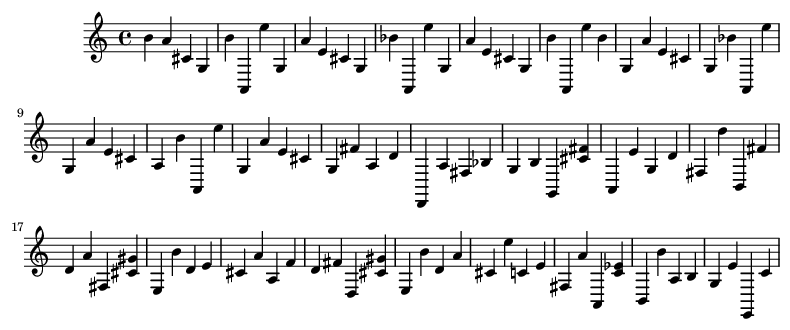

In [28]:

# Example: Create a Melody from a snippet of the Corpus
Melody_Snippet = chords_n_notes(Corpus[:100])

# Show the music sheet and play the music
show_and_play(Melody_Snippet)

In [29]:
count_num = Counter(Corpus)
print("\033[96m The total count of unique notes in the Corpus:\033[0m", len(count_num))

 The total count of unique notes in the Corpus: 397


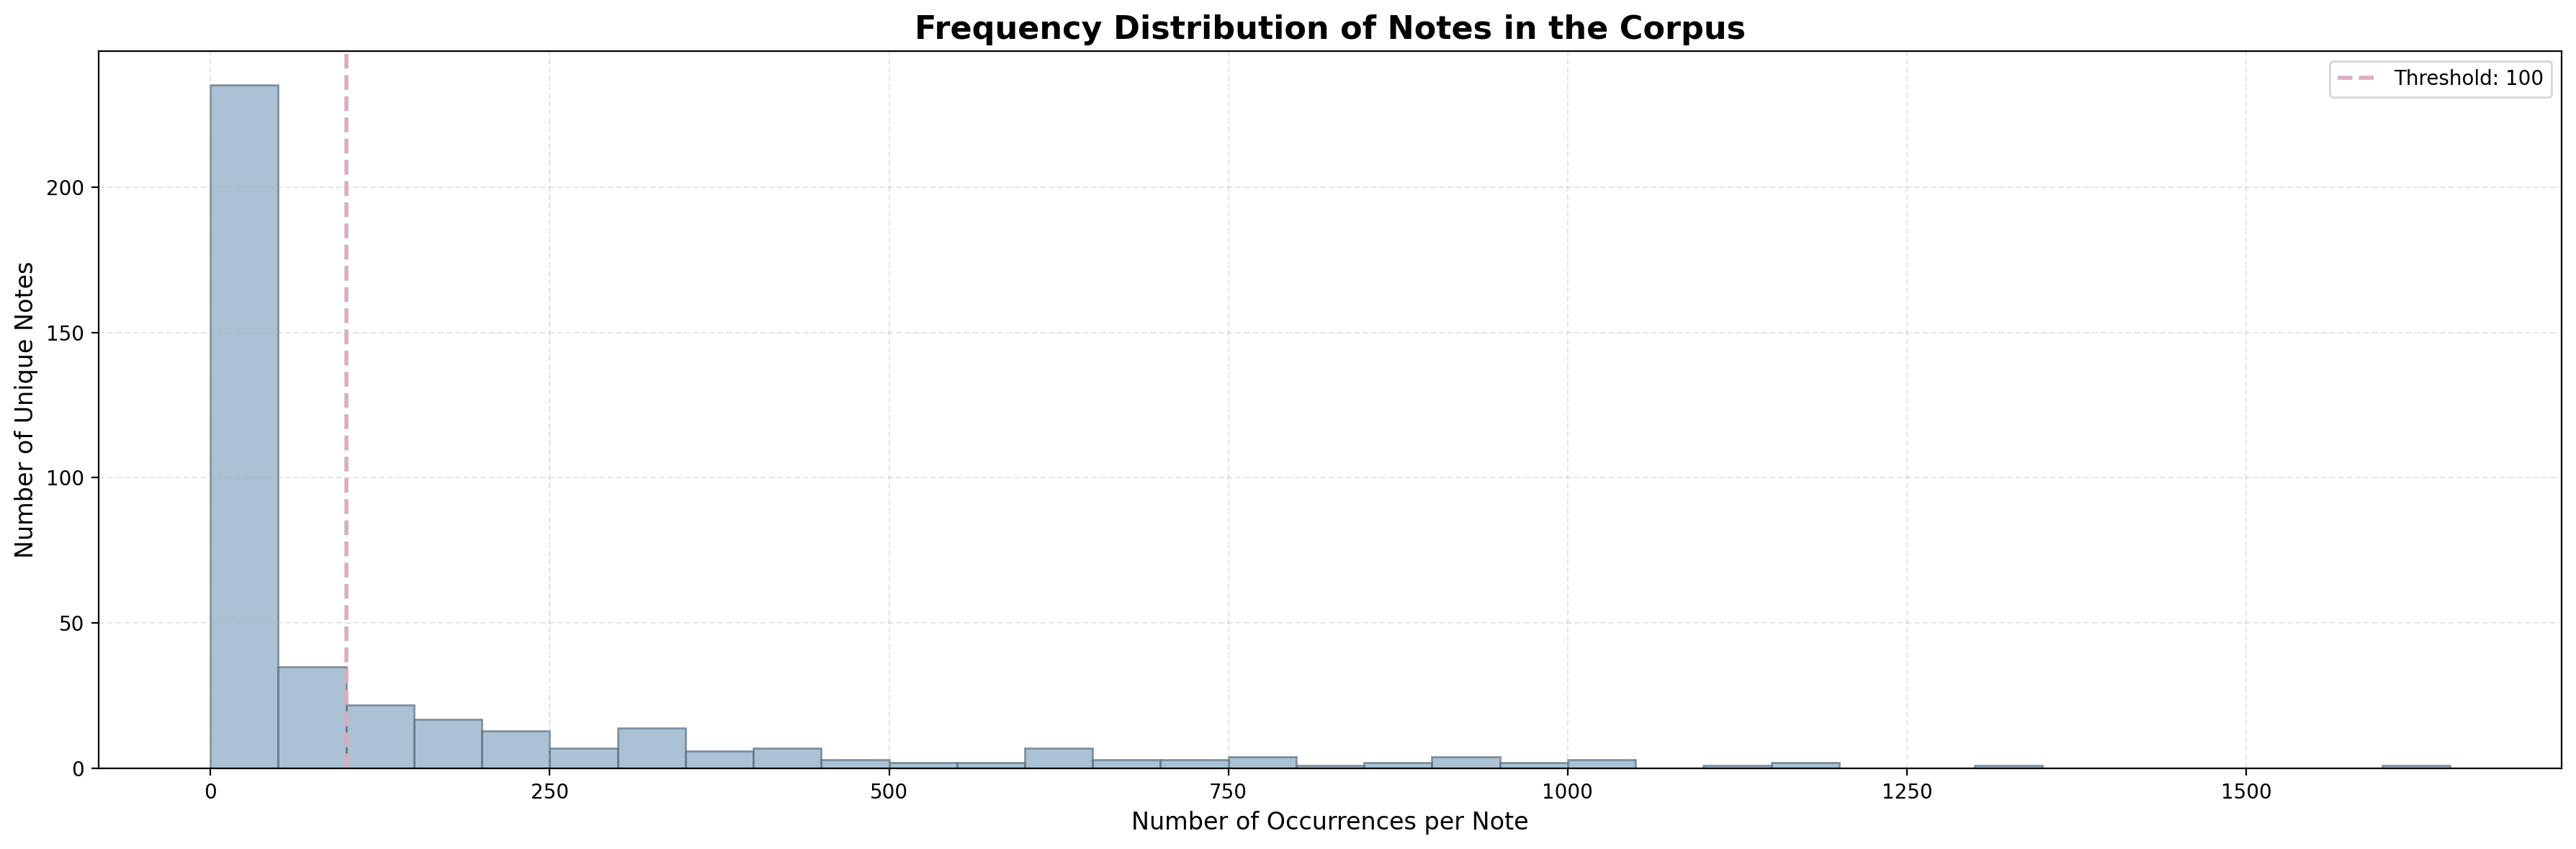

In [30]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
# Plotting the distribution of Notes with enhanced aesthetics
plt.figure(figsize=(18, 6))
bins = np.arange(0, max(Recurrence) + 50, 50)
plt.hist(Recurrence, bins=bins, color="#86A9C1", edgecolor="#5D6F82", alpha=0.7)
plt.axvline(x=100, color="#DBACC1", linestyle='--', linewidth=2, label='Threshold: 100')
plt.title("Frequency Distribution of Notes in the Corpus", fontsize=16, weight='bold')
plt.xlabel("Number of Occurrences per Note", fontsize=12)
plt.ylabel("Number of Unique Notes", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("\033[96m The total count of notes that appear fewer than 100 times:\033[0m", len(rare_note))

for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("\033[96m The length of the Corpus after removing the rare notes:\033[0m", len(Corpus))

 The total count of notes that appear fewer than 100 times: 270
 The length of the Corpus after removing the rare notes: 53746


In [32]:
sym = sorted(list(set(Corpus)))
corp = len(Corpus) #length of corpus
symb = len(sym) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(sym))
reverse_mapping = dict((i, c) for i, c in enumerate(sym))

print("\033[96mTotal number of characters:\033[0m", corp)
print("\033[96mTotal number of unique characters:\033[0m", sym)


Total number of characters: 53746
Total number of unique characters: ['0', '0.1', '0.2', '0.2.5', '0.2.6', '0.2.6.8', '0.3', '0.3.5', '0.3.6', '0.3.6.9', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.5', '0.5.6', '0.6', '1', '1.2', '1.2.3', '1.2.4.8', '1.3', '1.3.6', '1.3.7', '1.3.8', '1.4', '1.4.6', '1.4.7', '1.4.7.10', '1.5', '1.5.6', '1.5.8', '1.6', '1.7', '10', '10.0', '10.0.3.6', '10.0.4', '10.0.5', '10.1', '10.1.3', '10.1.4', '10.1.5', '10.11', '10.11.2', '10.2', '10.2.5', '10.3', '11', '11.0', '11.0.2', '11.0.2.3', '11.0.4', '11.1', '11.1.6', '11.2', '11.2.5', '11.2.6', '11.3', '11.3.4', '11.3.5', '11.3.6', '11.4', '2', '2.3', '2.4', '2.4.5', '2.4.7', '2.4.8', '2.5', '2.5.7', '2.5.8', '2.5.9', '2.6', '2.6.8', '2.7', '2.8', '3', '3.4', '3.5', '3.5.10', '3.5.8', '3.5.8.11', '3.5.9', '3.6', '3.6.10', '3.6.8', '3.6.9', '3.7', '3.7.10', '3.8', '3.9', '4', '4.10', '4.5', '4.5.7', '4.6', '4.6.10', '4.6.11', '4.6.9', '4.7', '4.7.10', '4.7.11', '4.7.9', '4.8', '4.8.11', '4.9', '5', '5.10

In [33]:
length = 40
features = []
targets = []
for i in range(0, corp - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
data_ = len(targets)
print("\033[96mTotal count of sequences within the corpus:\033[0m", data_)

Total count of sequences within the corpus: 53706


In [34]:
# Normalize
X = (np.reshape(features, (data_, length, 1))) / float(len(sym))
y = tensorflow.keras.utils.to_categorical(targets)

In [35]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = Sequential()

# Bidirectional LSTM Layer 1
model.add(Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2),
                        input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layer 2
model.add(LSTM(256, return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layer 3
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Fully Connected Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(y.shape[1], activation='softmax'))

# Compile model
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [36]:
model.summary()


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ bidirectional (Bidirectional)   ‚îÇ (None, 40, 1024)       ‚îÇ     2,105,344 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 40, 1024)       ‚îÇ         4,096 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 40, 1024)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 40, 256)        ‚îÇ     1,311,744 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 40, 256)        ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 40, 256)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 128)            ‚îÇ       197,120 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 256)           

 Total params: 3,718,656 (14.19 MB)

 Trainable params: 3,715,840 (14.17 MB)

 Non-trainable params: 2,816 (11.00 KB)

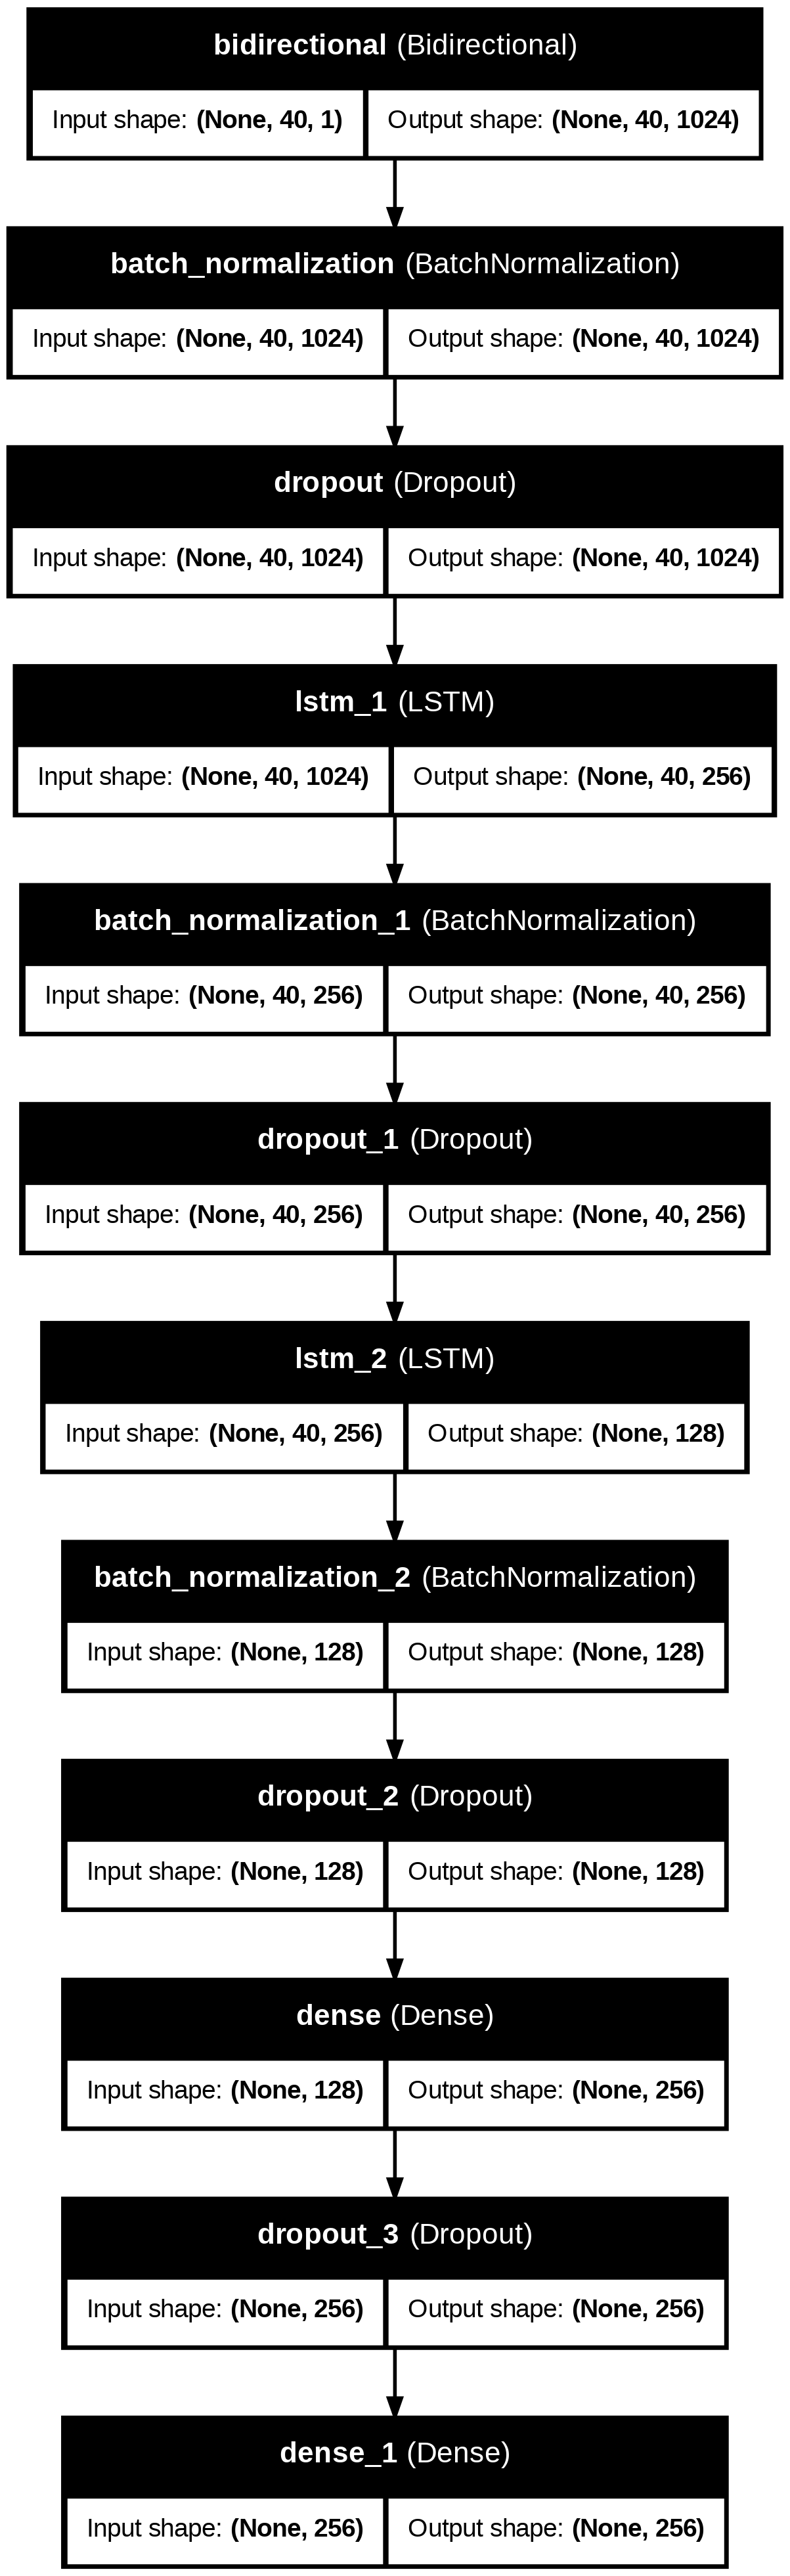

In [37]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [38]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50)


Epoch 1/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68s 321ms/step - accuracy: 0.0189 - loss: 5.0015
Epoch 2/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 325ms/step - accuracy: 0.0274 - loss: 4.5550
Epoch 3/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 317ms/step - accuracy: 0.0335 - loss: 4.4844
Epoch 4/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 319ms/step - accuracy: 0.0303 - loss: 4.4730
Epoch 5/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 324ms/step - accuracy: 0.0355 - loss: 4.4440
Epoch 6/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 321ms/step - accuracy: 0.0363 - loss: 4.4244
Epoch 7/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 325ms/step - accuracy: 0.0376 - loss: 4.4092
Epoch 8/50
168/168 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 323ms/step - 

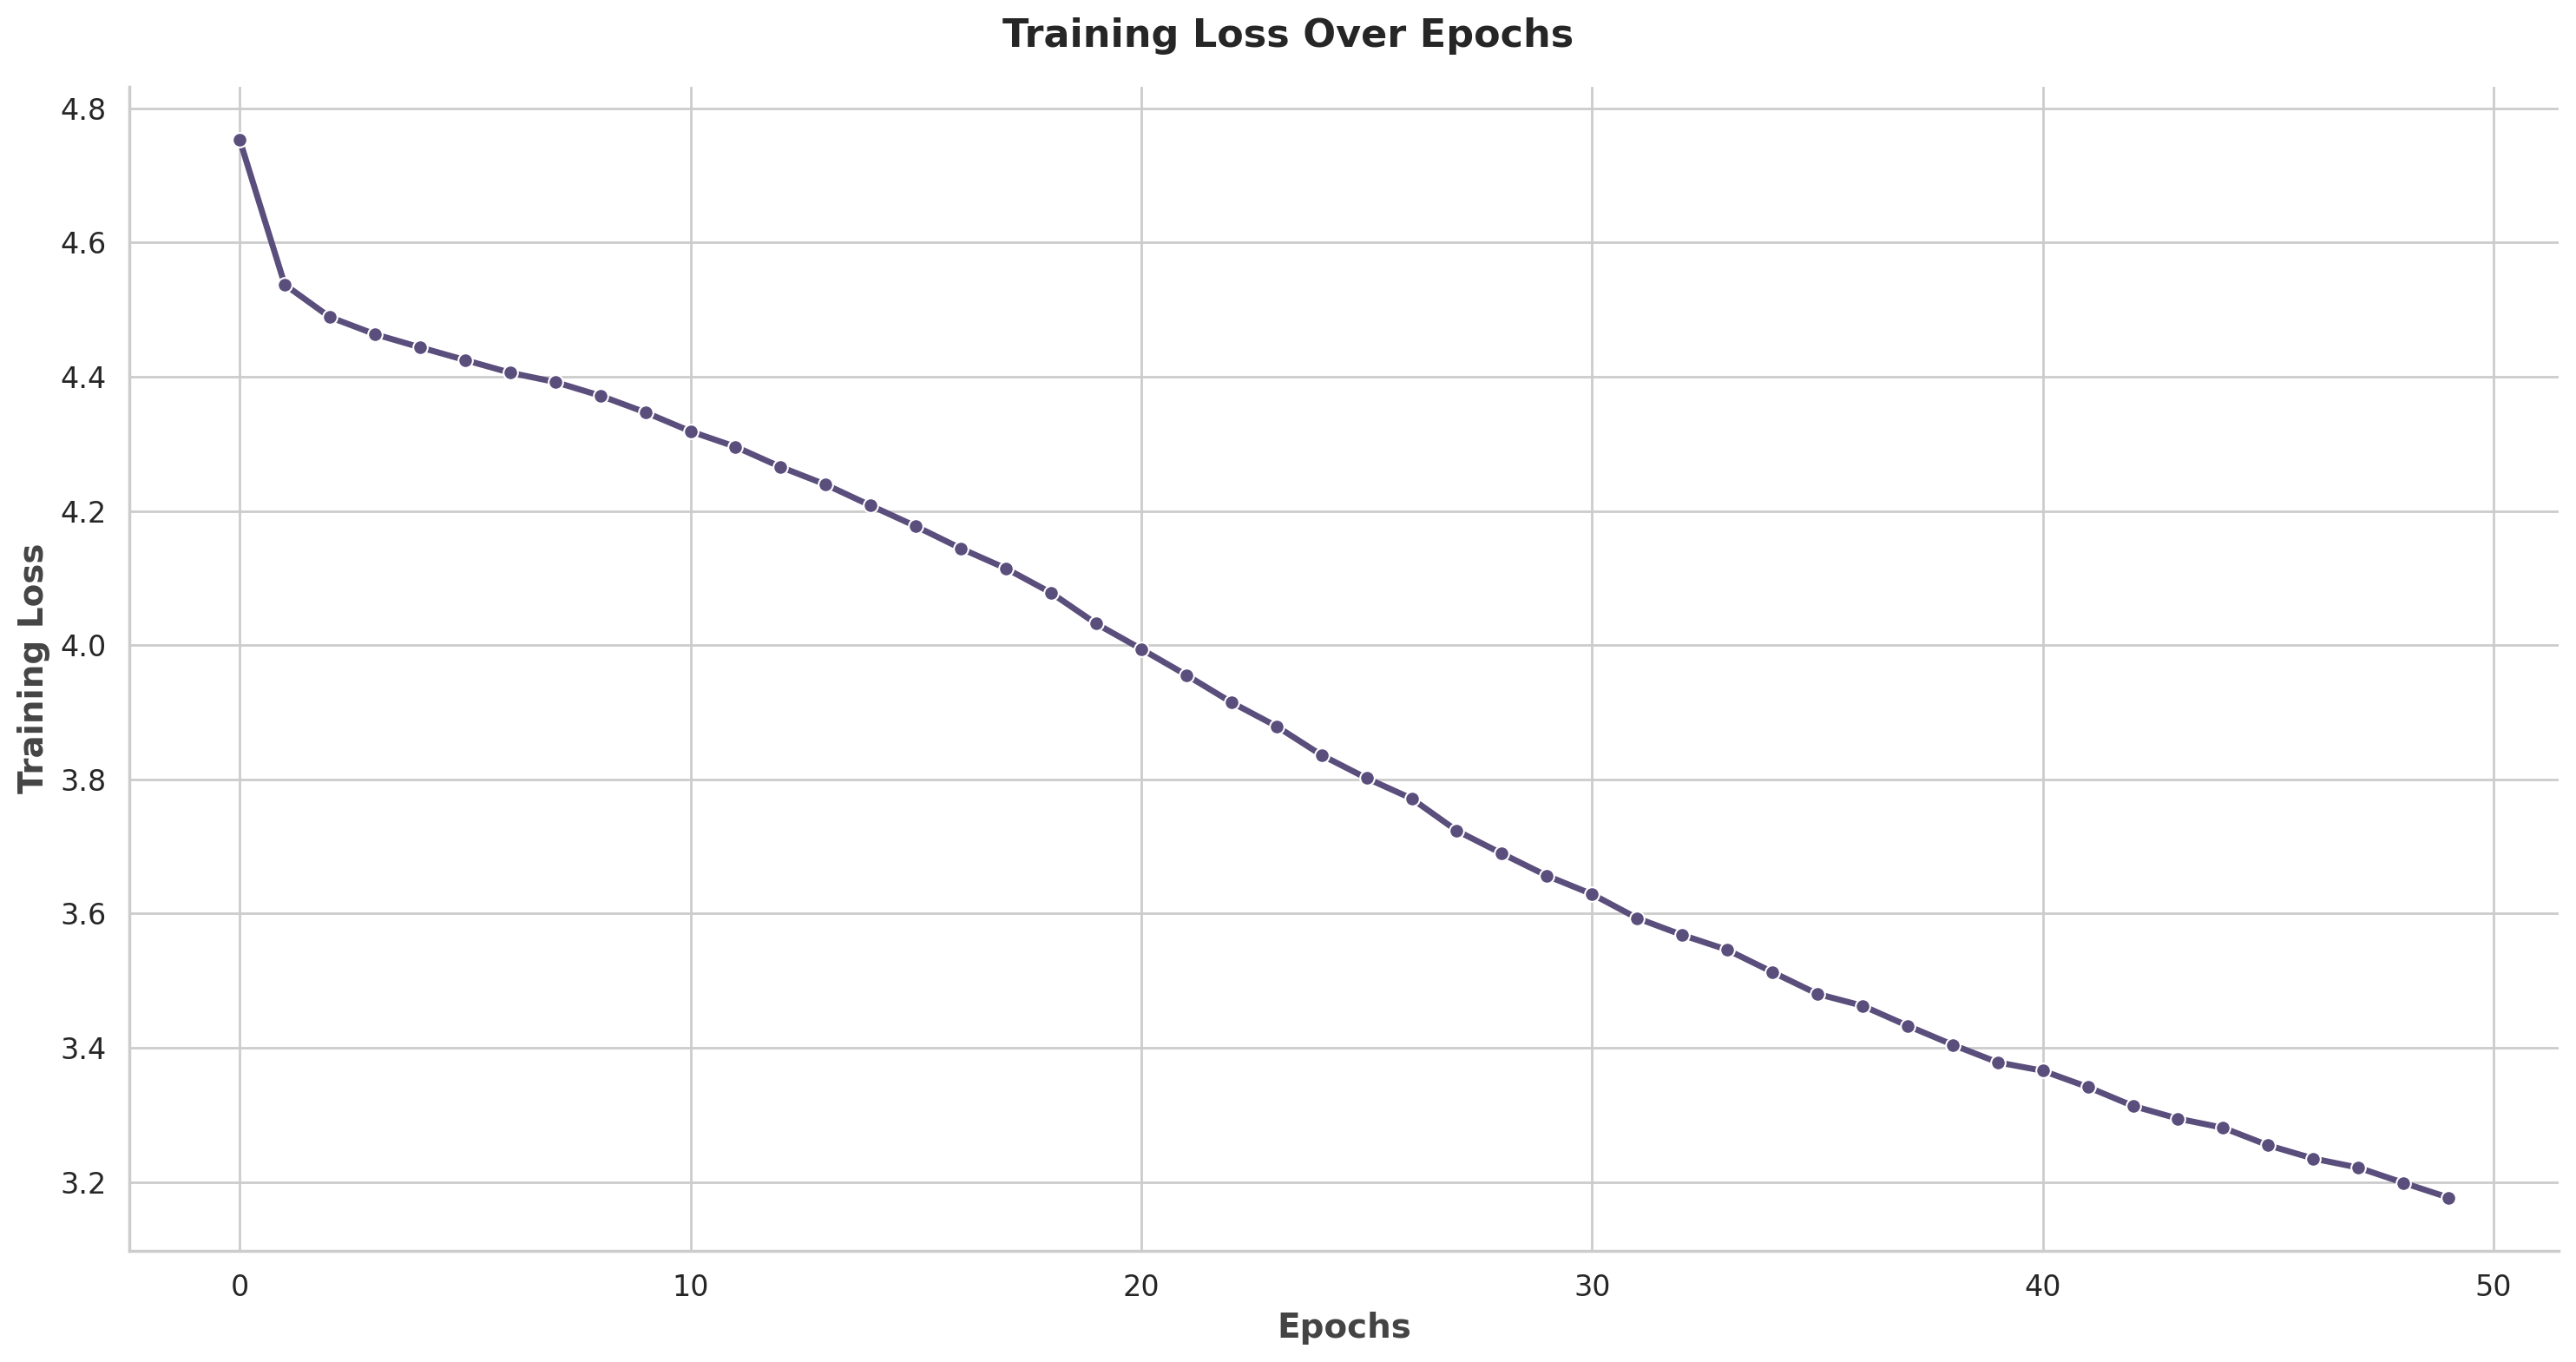

In [39]:
history_df = pd.DataFrame(history.history)
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15, 8),)
fig.suptitle("Training Loss Over Epochs", fontsize=16, fontweight='bold')
ax = sns.lineplot(
    data=history_df["loss"],
    linewidth=2.5,
    color="#5A4E7C",
    marker='o',
    markersize=6
)
ax.set_xlabel("Epochs", fontsize=14, fontweight='semibold', color="#444444")
ax.set_ylabel("Training Loss", fontsize=14, fontweight='semibold', color="#444444")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [54]:
from IPython.display import Image, display

def chords_n_notes(Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        if "." in i or i.isdigit():
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        offset += 1
    return stream.Stream(Melody)

def show_and_play(music):
    display(Image(str(music.write("lily.png"))))
    music.show('midi')

def Generator(count):
    seed_idx = np.random.randint(0, len(X_test) - 1)
    test = X_test[seed_idx]
    generated_indices = []

    for _ in range(count):
        test_input = test.reshape(1, length, 1)
        prediction = model.predict(test_input, verbose=0)[0]

        # Sampling with temperature
        prediction = np.log(prediction + 1e-8) / 1.0
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # Sampling instead of argmax to create more variation
        index = np.random.choice(len(prediction), p=prediction)

        generated_indices.append(index)

        # Normalize new input and shift window
        next_note = index / float(len(sym))
        test = np.append(test, [[next_note]], axis=0)
        test = test[1:]

    # Map back to note names
    generated_notes = [reverse_mapping[i] for i in generated_indices]

    # Convert notes to MIDI stream
    melody = chords_n_notes(generated_notes)
    show_and_play(melody)

    return generated_notes, melody
music_notes, melody_stream = Generator(100)

KeyboardInterrupt: 

üéº Melody Sample 1


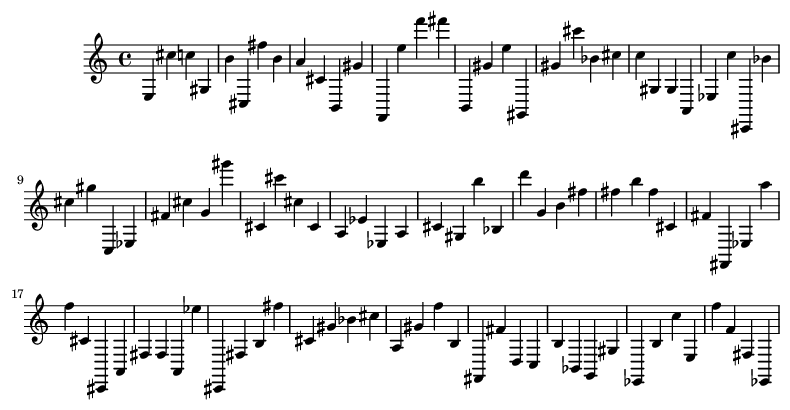

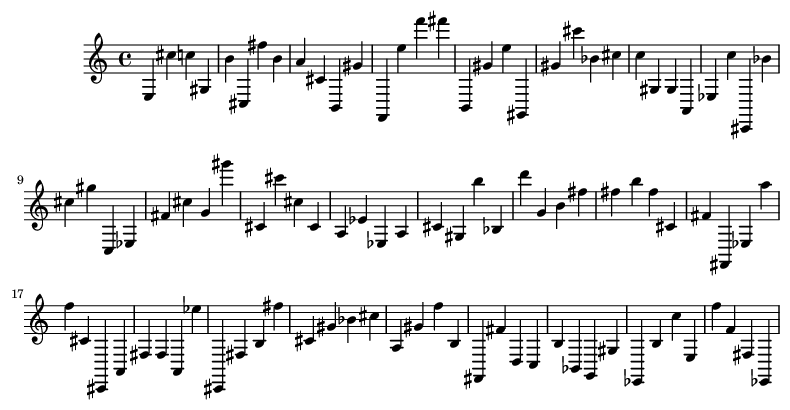

üéº Melody Sample 2


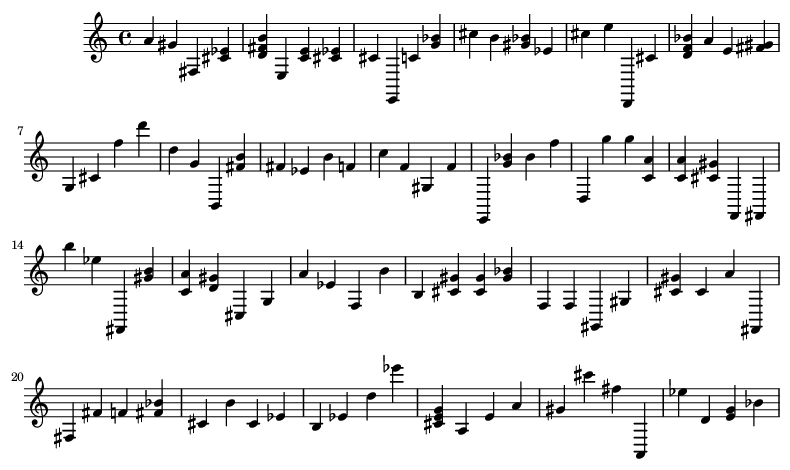

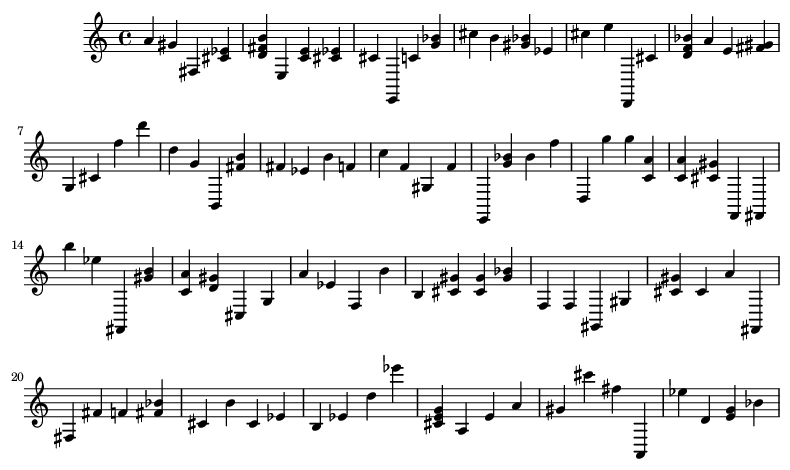

üéº Melody Sample 3


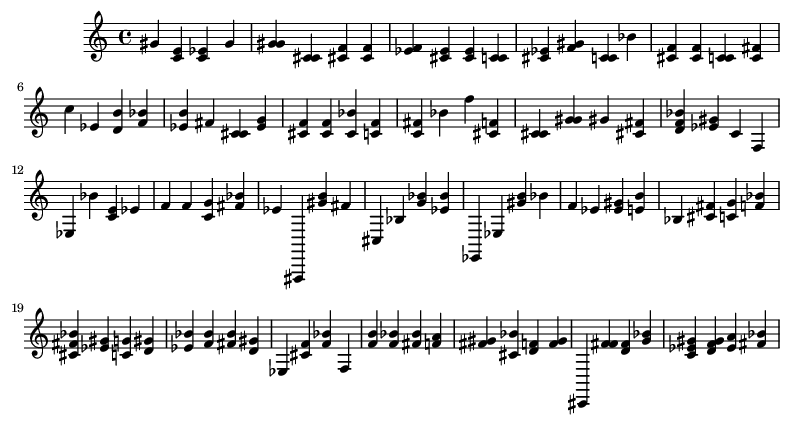

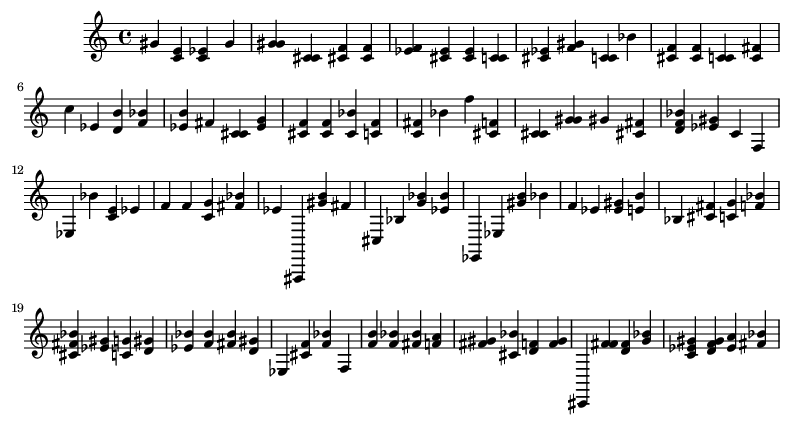

üéº Melody Sample 4


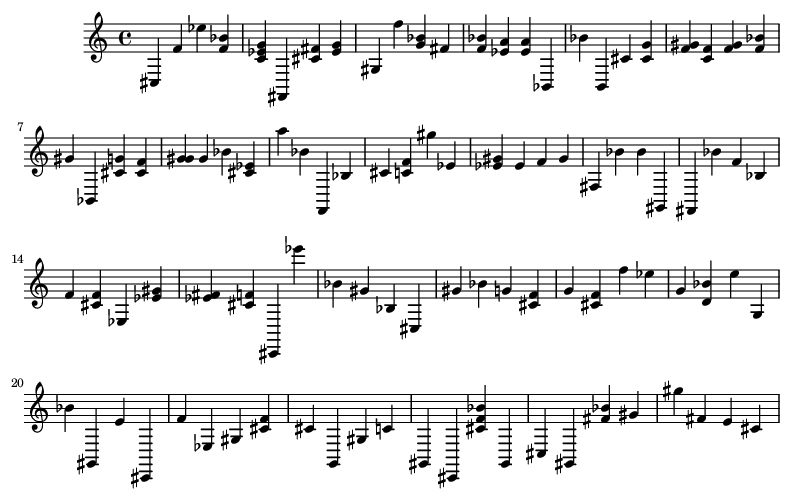

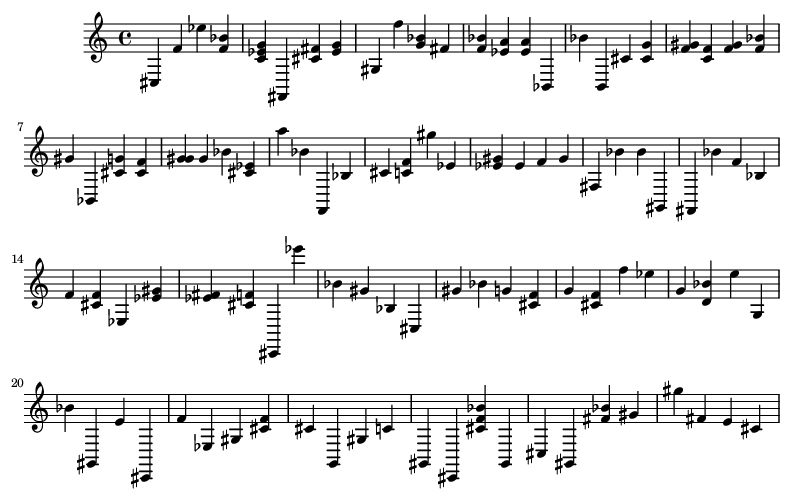

üéº Melody Sample 5


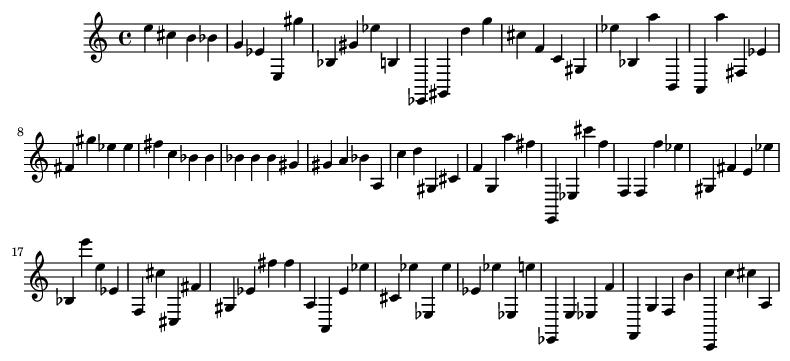

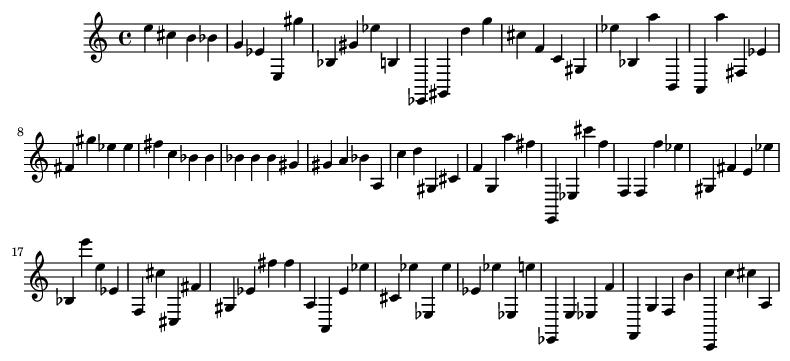

In [41]:
for i in range(5):
    print(f"\033[94müéº Melody Sample {i+1}\033[0m")
    notes, melody = Generator(100)
    show_and_play(melody)

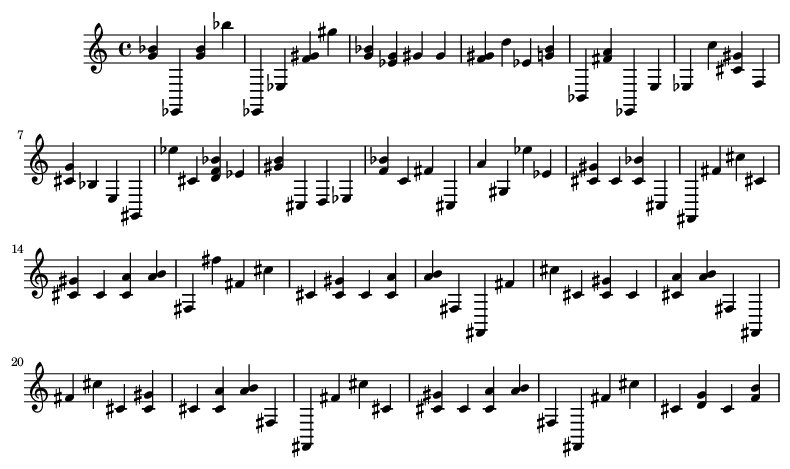

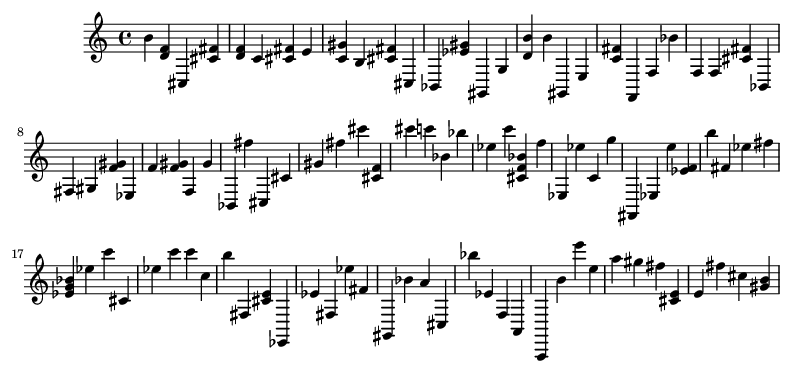

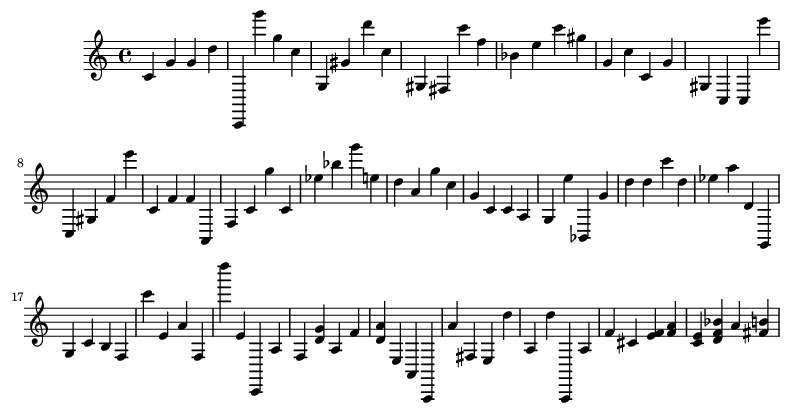

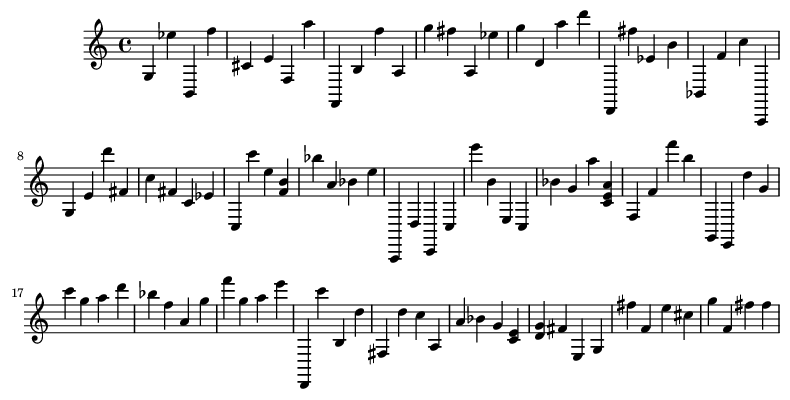

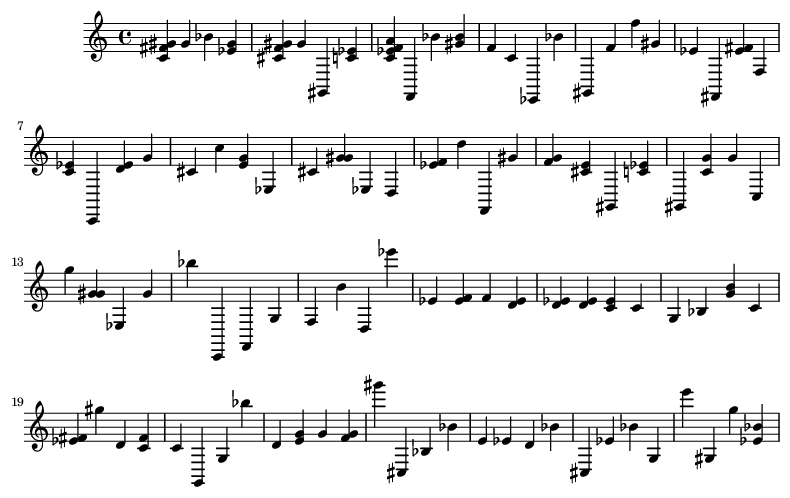

In [42]:
for i in range(5):
    notes, melody = Generator(100)
    melody.write('midi', fp=f"generated_melody_{i+1}.mid")

It doesn't sound that great, and it is consistently playing quarter notes. Let's try to make it learn varied note durations.

In [48]:
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import * # Keep this for brevity, though explicit imports are better
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model, to_categorical # Added to_categorical
from tensorflow.keras.models import Sequential, Model # Added Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Embedding, Input, Concatenate, Reshape # Added Embedding, Input, Concatenate, Reshape
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax, Adam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

# --- Ensure all_midis is loaded here if it's not from a previous cell ---
# Example of how all_midis should be loaded (assuming 'chopin/' is your folder)
import os
filepath = "./chopin/"
all_midis = []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath + i
        try:
            midi = converter.parse(tr)
            all_midis.append(midi)
        except Exception as e:
            print(f"Error loading MIDI file {tr}: {e}. Skipping.")
# --- End of all_midis loading ---


# Updated extract_notes_and_durations_from_streams function for corrected MIDI access
def extract_notes_and_durations_from_streams(midi_streams):
    all_events = []
    for midi_stream_obj in midi_streams:
        try:
            elements = midi_stream_obj.flat.notesAndRests

            for element in elements:
                if isinstance(element, note.Note):
                    all_events.append( (str(element.pitch.midi), element.quarterLength) )
                elif isinstance(element, chord.Chord):
                    # --- FIX APPLIED HERE ---
                    # Check if there are any pitches in the chord before trying to sort them
                    if element.pitches: # This checks if the pitches iterable is not empty
                        all_events.append( ('.'.join(str(n.midi) for n in element.pitches.sorted), element.quarterLength) )
                    else:
                        # If a chord has no pitches, skip it or represent it in some way
                        print(f"Warning: Found a chord with no pitches in stream. Skipping.")
                        continue # Skip this element if it's an empty chord
                    # --- END FIX ---
                elif isinstance(element, note.Rest):
                    all_events.append( ('rest', element.quarterLength) )
        except Exception as e:
            print(f"Warning: Could not process stream from file due to: {e}. Skipping this stream.")
    return all_events

# Make sure all_midis is correctly loaded here (as per your previous setup)
import os
filepath = "./chopin/"
all_midis = []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath + i
        try:
            midi = converter.parse(tr)
            all_midis.append(midi)
        except Exception as e:
            print(f"Error loading MIDI file {tr}: {e}. Skipping.")

# Then call the extraction function:
Corpus_events = extract_notes_and_durations_from_streams(all_midis)
print("Total events (notes, chords, rests) in all the Chopin midis:", len(Corpus_events))


# --- Rest of your code for prepare_sequences_enhanced, create_multi_output_model, etc. ---
# I'm including the full structure of the previous solution for context,
# but the primary fix is in `extract_notes_and_durations_from_streams`.

def prepare_sequences_enhanced(events, sequence_length):
    # Create a vocabulary of all unique event strings and unique durations
    event_strings = sorted(list(set([e[0] for e in events])))
    duration_floats = sorted(list(set([e[1] for e in events])))

    # Map both to integers
    event_to_int = {event_str: i for i, event_str in enumerate(event_strings)}
    duration_to_int = {dur_float: i for i, dur_float in enumerate(duration_floats)}

    # Reverse mappings
    int_to_event = {i: event_str for i, event_str in enumerate(event_strings)}
    int_to_duration = {i: dur_float for i, dur_float in enumerate(duration_floats)}

    # Total vocabulary size for events and durations
    n_event_vocab = len(event_strings)
    n_duration_vocab = len(duration_floats)

    input_sequences_events = []
    input_sequences_durations = []
    target_events = []
    target_durations = []

    # Ensure enough events for sequences
    if len(events) < sequence_length + 1:
        raise ValueError(f"Not enough events ({len(events)}) for sequence_length ({sequence_length}).")

    for i in range(len(events) - sequence_length):
        seq_in = events[i : i + sequence_length]
        seq_out_event, seq_out_duration = events[i + sequence_length]

        input_sequences_events.append([event_to_int[e[0]] for e in seq_in])
        input_sequences_durations.append([duration_to_int[e[1]] for e in seq_in])
        target_events.append(event_to_int[seq_out_event])
        target_durations.append(duration_to_int[seq_out_duration])

    # Convert to numpy arrays
    network_input_events = np.array(input_sequences_events)
    network_input_durations = np.array(input_sequences_durations)

    # One-hot encode targets
    network_output_events = to_categorical(target_events, num_classes=n_event_vocab)
    network_output_durations = to_categorical(target_durations, num_classes=n_duration_vocab)

    return (network_input_events, network_input_durations,
            network_output_events, network_output_durations,
            event_to_int, int_to_event, duration_to_int, int_to_duration,
            n_event_vocab, n_duration_vocab)

# Use this new preparation:
sequence_length = 100
(X_events, X_durations,
 y_events, y_durations,
 event_to_int, int_to_event, duration_to_int, int_to_duration,
 n_event_vocab, n_duration_vocab) = prepare_sequences_enhanced(Corpus_events, sequence_length)

# Splitting data for training and testing
X_train_events, X_test_events, y_train_events, y_test_events = train_test_split(X_events, y_events, test_size=0.2, random_state=42)
X_train_durations, X_test_durations, y_train_durations, y_test_durations = train_test_split(X_durations, y_durations, test_size=0.2, random_state=42)


def create_multi_output_model(sequence_length, n_event_vocab, n_duration_vocab):
    # Input for events
    input_events = Input(shape=(sequence_length,), name='input_events')
    event_embedding = Embedding(input_dim=n_event_vocab, output_dim=100, input_length=sequence_length)(input_events)

    # Input for durations
    input_durations = Input(shape=(sequence_length,), name='input_durations')
    duration_embedding = Embedding(input_dim=n_duration_vocab, output_dim=50, input_length=sequence_length)(input_durations) # Smaller embedding for durations

    # Concatenate embeddings to feed into LSTMs
    combined_input = Concatenate()([event_embedding, duration_embedding])

    # LSTM Layers
    lstm1 = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2))(combined_input)
    norm1 = BatchNormalization()(lstm1)
    drop1 = Dropout(0.3)(norm1)

    lstm2 = LSTM(512, return_sequences=True, recurrent_dropout=0.2)(drop1)
    norm2 = BatchNormalization()(lstm2)
    drop2 = Dropout(0.3)(norm2)

    lstm3 = LSTM(256)(drop2) # Last LSTM without return_sequences
    norm3 = BatchNormalization()(lstm3)
    drop3 = Dropout(0.3)(norm3)

    # Dense layers
    dense1 = Dense(256, activation='relu')(drop3)
    drop4 = Dropout(0.4)(dense1)

    # Output branches
    output_event = Dense(n_event_vocab, activation='softmax', name='output_event')(drop4)
    output_duration = Dense(n_duration_vocab, activation='softmax', name='output_duration')(drop4)

    # Create the model
    model = Model(inputs=[input_events, input_durations], outputs=[output_event, output_duration])

    # Compile the model
    opt = Adam(learning_rate=0.001)
    model.compile(loss={'output_event': 'categorical_crossentropy', 'output_duration': 'categorical_crossentropy'},
                  optimizer=opt,
                  metrics={'output_event': 'accuracy', 'output_duration': 'accuracy'})
    return model

# Create the model
multi_output_model = create_multi_output_model(sequence_length, n_event_vocab, n_duration_vocab)
# multi_output_model.summary() # Uncomment to see model summary
# plot_model(multi_output_model, show_shapes=True, show_layer_names=True) # Uncomment to plot model

# --- TqdmCallback for progress bar ---
from tqdm.keras import TqdmCallback

# Fit the model
print("Starting model training...")
history = multi_output_model.fit(
    {'input_events': X_train_events, 'input_durations': X_train_durations},
    {'output_event': y_train_events, 'output_duration': y_train_durations},
    epochs=50, # Consider starting with fewer epochs (e.g., 10-20) for initial testing
    batch_size=64,
    callbacks=[TqdmCallback(verbose=0)], # For progress bar
    validation_data=({'input_events': X_test_events, 'input_durations': X_test_durations},
                     {'output_event': y_test_events, 'output_duration': y_test_durations})
)



Total events (notes, chords, rests) in all the Chopin midis: 6812
Starting model training...


0epoch [00:00, ?epoch/s]

Epoch 1/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84s 864ms/step - loss: 5.5069 - output_duration_accuracy: 0.7696 - output_duration_loss: 0.9669 - output_event_accuracy: 0.0443 - output_event_loss: 4.5400 - val_loss: 4.6385 - val_output_duration_accuracy: 0.8369 - val_output_duration_loss: 0.7578 - val_output_event_accuracy: 0.0491 - val_output_event_loss: 3.8806
Epoch 2/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 70s 835ms/step - loss: 4.5570 - output_duration_accuracy: 0.8633 - output_duration_loss: 0.5032 - output_event_accuracy: 0.0626 - output_event_loss: 4.0538 - val_loss: 4.4363 - val_output_duration_accuracy: 0.8436 - val_output_duration_loss: 0.6447 - val_output_event_accuracy: 0.0745 - val_output_event_loss: 3.7916
Epoch 3/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 70s 835ms/step - loss: 4.4206 - output_duration_accuracy: 0.8537 - output_duration_loss: 0.5083 - output_event_accuracy: 0.0718 - ou

Saving model and mappings...


NameError: name 'pickle' is not defined

In [53]:
print(Corpus_events)

[('71', 0.25), ('rest', 0.5), ('69', 0.25), ('61', 0.25), ('55', 0.25), ('71', 0.5), ('45', 0.25), ('76', 0.25), ('55', 0.25), ('69', 0.25), ('64', 0.25), ('61', 0.25), ('55', 0.25), ('70', 0.5), ('45', 0.25), ('76', 0.25), ('55', 0.25), ('69', 0.25), ('64', 0.25), ('61', 0.25), ('55', 0.25), ('71', 0.25), ('45', 0.25), ('76', 0.25), ('71', 0.25), ('55', 0.25), ('69', 0.25), ('64', 0.25), ('61', 0.25), ('55', 0.25), ('70', 0.5), ('45', 0.25), ('76', 0.25), ('55', 0.25), ('69', 0.25), ('64', 0.25), ('61', 0.25), ('57', 0.25), ('71', 0.5), ('45', 0.25), ('76', 0.25), ('55', 0.25), ('69', 0.25), ('64', 0.25), ('61', 0.25), ('55', 0.25), ('66', 0.25), ('57', 0.25), ('62', 0.25), ('38', 0.25), ('57', 0.25), ('54', 0.25), ('58', 0.25), ('55', 0.25), ('59', 0.25), ('43', 0.25), ('77', 3.0), ('34', 0.5), ('53', 0.5), ('58', 1.0), ('46', 1.0), ('rest', Fraction(1, 3)), ('rest', 0.5), ('48', 2.5), ('36', 2.5), ('51', 0.5), ('39', 0.5), ('56', 0.5), ('44', 0.5), ('58', 0.5), ('46', 0.5), ('60', 0

In [49]:
import pickle

Saving model and mappings...
Model and mappings saved successfully.
--- Starting Music Generation ---

üéº Melody Sample 1


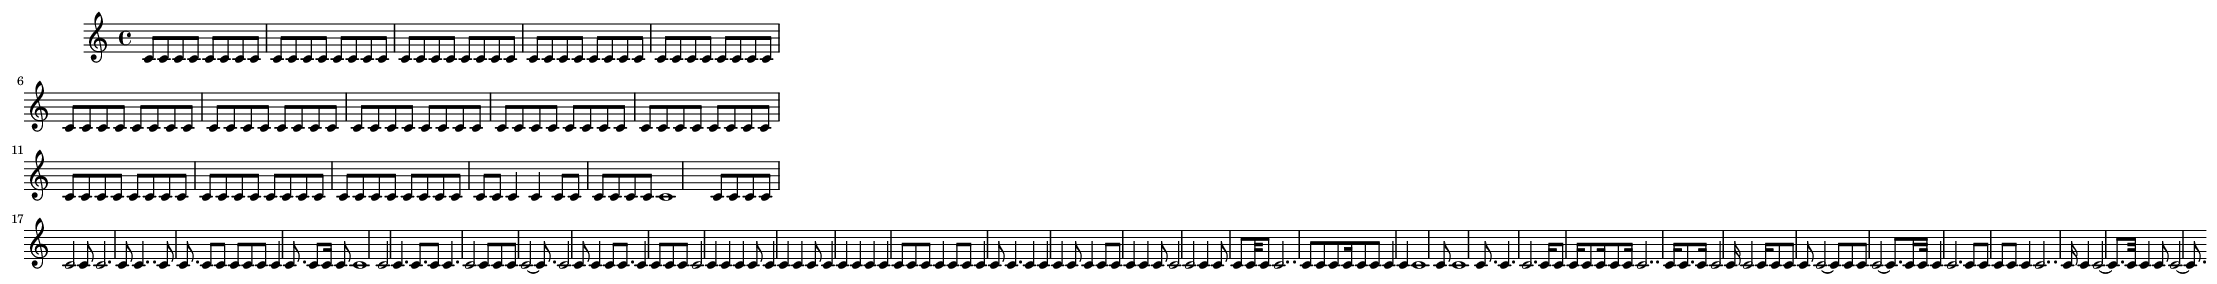


üéº Melody Sample 2


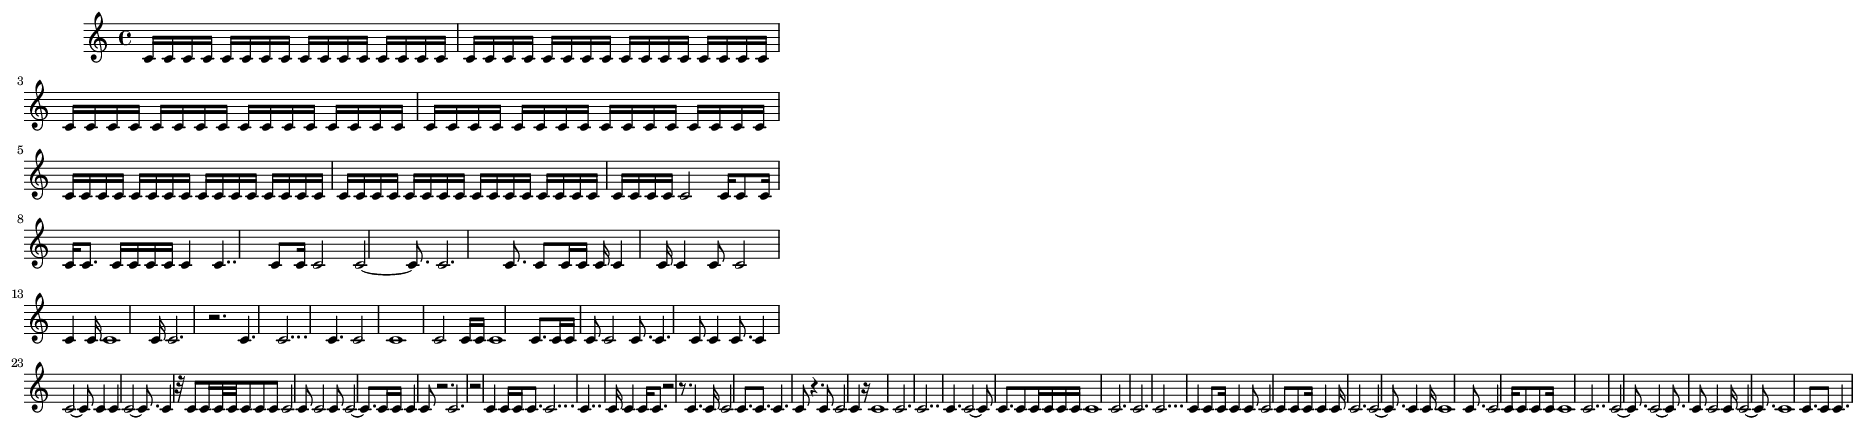


üéº Melody Sample 3


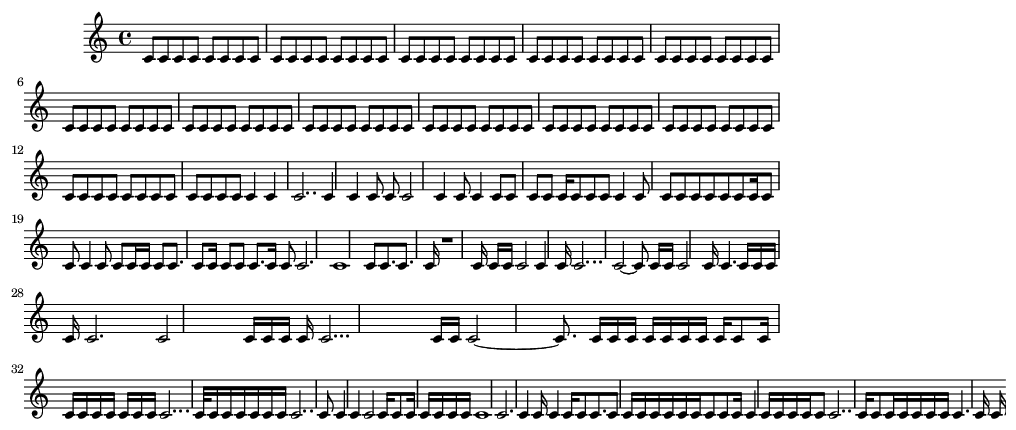


üéº Melody Sample 4


KeyboardInterrupt: 

In [52]:
# Save the model
print("Saving model and mappings...")
multi_output_model.save("lstm_music_polyphonic_model.h5")
with open("event_to_int.pkl", "wb") as f:
    pickle.dump(event_to_int, f)
with open("int_to_event.pkl", "wb") as f:
    pickle.dump(int_to_event, f)
with open("duration_to_int.pkl", "wb") as f:
    pickle.dump(duration_to_int, f)
with open("int_to_duration.pkl", "wb") as f:
    pickle.dump(int_to_duration, f)
print("Model and mappings saved successfully.")


# Helper function to convert events to music21 objects
def events_to_stream(generated_events_and_durations):
    score = stream.Score()
    offset = 0.0

    for event_str, duration_val in generated_events_and_durations:
        if event_str == 'rest':
            element = note.Rest(quarterLength=duration_val)
        elif '.' in event_str: # It's a chord
            midi_nums = [int(n) for n in event_str.split('.')]
            notes_in_chord = []
            for m_num in midi_nums:
                notes_in_chord.append(note.Note(m_num))
            element = chord.Chord(notes_in_chord, quarterLength=duration_val)
        else: # It's a single note
            # Ensure the note is created with the MIDI number directly
            element = note.Note() # Create a blank note
            element.midi = int(event_str) # Set its MIDI value
            element.quarterLength = duration_val

        element.offset = offset
        score.append(element)
        offset += duration_val # Advance offset by the duration of the current element

    return score

# Updated Generator function
def Generator_enhanced(count, model, X_test_events, X_test_durations, int_to_event, int_to_duration, sequence_length):
    # Select a random seed sequence from test data
    seed_idx = np.random.randint(0, len(X_test_events) - 1)
    current_input_events = X_test_events[seed_idx]
    current_input_durations = X_test_durations[seed_idx]

    generated_events_and_durations = []

    # Initial seed events for reconstruction (optional, but good for context)
    # The generator only generates *new* events, so if you want the start to be part of the output
    # you'd include the seed. For now, let's include it.
    for i in range(sequence_length):
        generated_events_and_durations.append((int_to_event[current_input_events[i]], int_to_duration[current_input_durations[i]]))

    for _ in range(count):
        # Reshape for model input
        input_events_reshaped = current_input_events.reshape(1, sequence_length)
        input_durations_reshaped = current_input_durations.reshape(1, sequence_length)

        # Predict next event and duration
        predictions = model.predict({'input_events': input_events_reshaped, 'input_durations': input_durations_reshaped}, verbose=0)
        pred_event = predictions[0][0] # First output (event), first batch element
        pred_duration = predictions[1][0] # Second output (duration), first batch element

        # Sample next event (with temperature)
        temp = 4.0 # Adjust temperature (higher = more random, lower = more deterministic)
        pred_event_scaled = np.log(pred_event + 1e-8) / temp
        exp_preds_event = np.exp(pred_event_scaled)
        pred_event_probs = exp_preds_event / np.sum(exp_preds_event)
        next_event_int = np.random.choice(len(pred_event_probs), p=pred_event_probs)

        # Sample next duration (with temperature)
        pred_duration_scaled = np.log(pred_duration + 1e-8) / temp
        exp_preds_duration = np.exp(pred_duration_scaled)
        pred_duration_probs = exp_preds_duration / np.sum(exp_preds_duration)
        next_duration_int = np.random.choice(len(pred_duration_probs), p=pred_duration_probs)

        # Append generated event and duration (as their original string/float values)
        generated_events_and_durations.append((int_to_event[next_event_int], int_to_duration[next_duration_int]))

        # Update current input sequence for the next prediction
        # Use np.delete and np.append for robustness if current_input_events/durations aren't 1D
        current_input_events = np.append(current_input_events[1:], [next_event_int], axis=0)
        current_input_durations = np.append(current_input_durations[1:], [next_duration_int], axis=0)

    # Convert the generated events and durations back into a music21 stream
    melody_stream = events_to_stream(generated_events_and_durations)
    return generated_events_and_durations, melody_stream


# --- Run Generation ---
print("\033[92m--- Starting Music Generation ---\033[0m")
# Make sure multi_output_model is trained, and mappings are loaded if running in a new session.
# (For this example, it's assumed they are in memory from the training step above)

# You will need X_test_events and X_test_durations defined.
# If you run the script end-to-end, they will be defined from the train_test_split.
# If running only generation, load them from saved data.
# For example:
# with open("event_to_int.pkl", "rb") as f: event_to_int = pickle.load(f)
# with open("int_to_event.pkl", "rb") as f: int_to_event = pickle.load(f)
# with open("duration_to_int.pkl", "rb") as f: duration_to_int = pickle.load(f)
# with open("int_to_duration.pkl", "rb") as f: int_to_duration = pickle.load(f)
# multi_output_model = tf.keras.models.load_model("lstm_music_polyphonic_model.h5")
# You'd also need to load/recreate X_test_events, X_test_durations if starting fresh.


for i in range(5): # Generate 1 sample for testing initially
    print(f"\n\033[94müéº Melody Sample {i+1}\033[0m")
    generated_events, melody_stream = Generator_enhanced(
        count=150, # Generate 150 new events
        model=multi_output_model,
        X_test_events=X_test_events,
        X_test_durations=X_test_durations,
        int_to_event=int_to_event,
        int_to_duration=int_to_duration,
        sequence_length=sequence_length
    )
    # Using the show_and_play defined earlier in your script:
    # Ensure it's correctly updated to use 'png' and optionally MuseScore as discussed
    def show_and_play(music):
        try:
            # Set music21 environment settings for image display if not already set
            us = environment.UserSettings()
            # us['lilypondPath'] = '/opt/homebrew/bin/lilypond' # Your LilyPond path
            # us['musescoreDirectPNGPath'] = '/Applications/MuseScore 4.app/Contents/MacOS/musescore' # Your MuseScore path

            image_path = str(music.write("lily.png")) # Request generic PNG
            display(Image(image_path))
        except Exception as e:
            print(f"Error showing music sheet (image): {e}")
            print("Attempting to play MIDI only.")
        music.show('midi')

    show_and_play(melody_stream)

print("\n\033[92m--- Generation Complete ---\033[0m")